## Imports & function definitions

In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import squidpy as sq


from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, save_to_pickle, load_from_pickle
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from sklearn.cluster import KMeans

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


In [2]:
# This is the publication iteration of regions
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')

# Get unique region names
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()

# Get unique regions colors
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

for sample in samples:
    adata_slides[sample].obs['predicted_region'] = adata_slides[sample].obs['predicted_region'].replace(replace_dict)

# Create color legend
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
color_dict = dict(zip(regions,region_colors))

In [3]:

# Define functions
def get_spot_interfaces(dat, cluster_of_interest, interaction_cluster, annotation_key = 'predicted_region',added_key='proximity_analysis'):
    # Modified on 31.10. to make the interface subsetting work both ways

    # Create an observation column for spatial segmentation
    dat.obs[added_key] = np.nan
    distance_mat = dat.obsp['spatial_distances'].todense()

    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs[annotation_key][idx]

        if cl in [cluster_of_interest,interaction_cluster]:

            first_nhbor_idxs = np.where(distance_mat[:,idx]==1.0)[0] # Get first-term neighbor indices

            try:
                # If try fails, there are no matching clusters as keys in value_counts
                n_cl_neighbors = dat[first_nhbor_idxs].obs[annotation_key].value_counts()[cl] # find first-term neighbor cluster annotations POSSIBLE ERROR IF CL NOT IN DICT

                # Added this clause to control that only those with 'close' interactions with the interface cluster are included. 
                all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0]

                # Downgraded the number of required first neighbors to one
                if cl == cluster_of_interest:
                    if (n_cl_neighbors >= 0) & (sum(dat.obs[annotation_key][all_nhbor_indices] == interaction_cluster) >= 3):
                        dat.obs.at[obs_name,added_key] = cl

                elif cl == interaction_cluster:
                    if (n_cl_neighbors >= 0) & (sum(dat.obs[annotation_key][all_nhbor_indices] == cluster_of_interest) >= 3):
                        dat.obs.at[obs_name,added_key] = cl


            except:
                continue
    '''
    # Make a second loop to make sure the final cluster-of-interest annotations
    # are what's used to define proximal spots
    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs[added_key][idx]

        if cl == cluster_of_interest:
            
            all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0] 

            # Get the indices where neighboring spots are not the interest cluster 
            indices = np.where((dat.obs[added_key][all_nhbor_indices] != cl) & (dat.obs[annotation_key][all_nhbor_indices] == interaction_cluster))[0]

            # Update the 'proximity_analysis' column for the specific indices
            dat.obs.loc[dat.obs_names[all_nhbor_indices[indices]], added_key] = interaction_cluster
    '''
    # Modify the colors to maintain the original cluster color
    dat.obs[added_key] = dat.obs[added_key].astype('category')

    return(dat)



def most_common_interactions(dct):
    tuple_lst = []
    for key in dct.keys():
        [tuple_lst.append(tup) for tup in dct[key]]
    res = pd.Series(tuple_lst).value_counts()
    return(res)

def merge_dicts(dict1, dict2):
    merged_dict = {}

    for key, value in dict1.items():
        if key in dict2:
            merged_dict[key] = [value, dict2[key], value - dict2[key]]
        else:
            merged_dict[key] = [value, 0, value]

    for key, value in dict2.items():
        if key not in merged_dict:
            merged_dict[key] = [0, value, 0 - value]

    return merged_dict

def check_gene_marker_status(gene):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_231107.pkl')

    for r in regions:
        fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
        fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
        if fishers_test_df['gene'].str.contains(gene).any(): 
            print(fishers_test_df[fishers_test_df['gene']==gene])
            print('')

def check_top_markers(r,n=20):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_231107.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    return fishers_test_df[:n]


def get_ligrec_results(results_dict,source_region, target_region, pval = 0.01,reverse=False):
    # Function only reports those means that have a below-threshold p-value

    if reverse:
        source = source_region
        source_region = target_region
        target_region = source

    for i,s in enumerate(list(results_dict.keys())):
        means = results_dict[s]['means'][source_region][target_region]
        pvals = results_dict[s]['pvalues'][source_region][target_region]
        means = pd.DataFrame(means[pvals[pvals<pval].index])
        means = means.rename(columns={target_region:s})
        meta = results_dict[s]['metadata'].loc[means.index]

        if i==0:
            means_all = means
            metas_all = meta
        else:
            means_all = pd.merge(means_all,means,how='outer',left_index=True,right_index=True)
            metas_all = pd.concat([metas_all,meta],axis=0)

    # Drop duplicate indices
    metas_all.drop_duplicates(inplace=True)
    # Option of returning the results dict if needed
    return means_all, metas_all

def filter_ligrec_results(ligrec_res_dict,valid_samples):
    for k in list(ligrec_res_dict.keys()):
        df_sum = ligrec_res_dict[k].copy()
        df_sum = df_sum[[c for c in df_sum.columns if c in valid_samples]]
        ligrec_res_dict[k] = df_sum
    
    return(ligrec_res_dict)


def format_dotplot_df(plot_df, interfaces, n_interactions_per_interface=10, filter_by_n_regions=0,filter_duplicates = True):
    
    plot_df = plot_df[plot_df['interaction'].isin(interfaces)]
    # Filter out interactions that are present in all
    if filter_by_n_regions:
        val_counts = plot_df['molecules'].value_counts()
        not_in_all_regions_idxs = val_counts[val_counts < len(interfaces)-filter_by_n_regions].index
        plot_df = plot_df.loc[not_in_all_regions_idxs]

    final_idxs_list = []

    for k in interfaces:

        df_sum = plot_df[plot_df['interaction'] == k].sort_values(['pct_in','mean'],ascending=False)

        ####### R/L DUPLICATE FILTERING BEGINS HERE ######
        if filter_duplicates:
            l_list = []
            r_list = []
            valid_idxs = []
            for idx,tup in enumerate(df_sum['molecules']):
                if ((tup[0] not in l_list) & (tup[1] not in r_list)):
                    l_list.append(tup[0])
                    r_list.append(tup[1])
                    valid_idxs.append(idx)

            df_sum = df_sum.iloc[valid_idxs]
        ####### STOPS HERE ######   

        final_idxs_list += df_sum[:n_interfaces_per_interface].sort_index().index.tolist()

    plot_df = plot_df.loc[pd.Series(final_idxs_list).unique().tolist()]
    plot_df.loc[plot_df['pct_in'] == 0,'pct_in'] = np.nan

    return(plot_df)

def cluster_rows(df,num_clusters=7):
    # Perform K-means clustering with the desired number of clusters

    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df)

    # Get the cluster labels assigned to each row
    cluster_labels = kmeans.labels_

    # Add the cluster labels as a new column in the original dataframe
    df['cluster_label'] = cluster_labels

    # Sort the dataframe based on the cluster labels
    df_sorted = df.sort_values(by=['cluster_label'])

    idx = []
    for l in df_sorted['cluster_label'].unique():
        idx += df_sorted[df_sorted['cluster_label']==l].sort_index().index.tolist()
    df_sorted.drop(columns='cluster_labels',inplace=True)

    return(df_sorted)


In [86]:
check_gene_marker_status('EGF')

    gene  deg in  adj_pval interface
608  EGF       4  0.017117     Tumor

     gene  deg in  adj_pval           interface
7595  EGF       1       1.0  Luminal epithelium

     gene  deg in  adj_pval         interface
9242  EGF       0       1.0  Basal epithelium

     gene  deg in  adj_pval                interface
9674  EGF       0       1.0  Intermediate epithelium

     gene  deg in  adj_pval interface
9786  EGF       0       1.0    Immune

     gene  deg in  adj_pval    interface
9463  EGF       0       1.0  Endothelium

     gene  deg in  adj_pval   interface
9705  EGF       0       1.0  Fibroblast

     gene  deg in  adj_pval interface
9672  EGF       0       1.0    Muscle



In [65]:
df = check_top_markers('Intermediate epithelium',n=50)
for g in df['gene']:
    print(g)

MMP7
PIGR
CP
GPRC5A
MUC1
ELF3
NCOA7
CFB
SLPI
LCN2
LXN
GABRP
TNFRSF21
KRT7
TNFAIP2
RHOV
SOD2
KLF5
S100P
LTF
RARRES1
ASS1
CXCL16
S100A2
ATP1B1
SAA1
CDH3
CLDN4
CXCL2
CFTR
ANXA2
WFDC2
ITGB6
KRT19
SCUBE2
PDZK1IP1
OLFM4
SCNN1A
KRT17
ITGA3
CEACAM1
CLDN1
CRABP2
UBD
CXCL1
LAMC2
SERPINA1
SCGB3A1
MET
PTGES


## Subset proximal spots, calculate receptor-ligand analysis and plot

In [ ]:
import matplotlib.patches as patches

# Create an empty list to store legend handles
legend_handles = []

# Iterate over the dictionary items
for name, color in color_dict.items():
    # Create a colored circle patch
    patch = patches.Patch(color=color, label=name)
    # Add the patch to the legend handles list
    legend_handles.append(patch)

In [ ]:
from itertools import combinations
region_combinations = list(combinations(regions,2))

In [ ]:
for tup in region_combinations:
    source = tup[0]
    target = tup[1]
    valid_samples = []

    it=0
    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

    for i in range(5):
        for j in range(8):
            
            # There are at least 10 of both regions
            if it < len(samples) :
                
                slide = adata_slides[samples[it]]
                # Using three rings you get 6 immediate neigbors, 12 second neigbors and 18 third neighbors
                sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=3)
        

                # First check to see if there are sufficient amount of spots to look for proximal ones
                if (slide.obs['predicted_region'].str.contains(source).sum() >= 10) & (slide.obs['predicted_region'].str.contains(target).sum() >= 10):
                    
                    slide = get_spot_interfaces(slide, source, target)
    

                    if not (slide.obs['proximity_analysis'].isna().all()):
                        # Second check to see if there are sufficient amount of spots to plot and do ligrec (10)
                        if (slide.obs['proximity_analysis'].str.contains(source).sum() >= 10) & (slide.obs['proximity_analysis'].str.contains(target).sum() >= 10):

                            ## Plotting ##
                            slide.uns['proximity_analysis_colors'] = [color_dict[cat] for cat in slide.obs['proximity_analysis'].cat.categories]

                            # create spatial plot
                            sc.pl.spatial(slide,color='proximity_analysis',title=samples[it],
                                                    crop_coord=sample_crop_coord[samples[it]],
                                                    size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                                                    ax=axs[i,j],show=False
                                                    )
                            axs[i,j].set_xlabel(None)
                            axs[i,j].set_ylabel(None)

                            # Append this sample to the list
                            valid_samples.append(samples[it])

                        else:
                            axs[i,j].set_visible(False)
                    else:
                        axs[i,j].set_visible(False)
                else:
                    axs[i,j].set_visible(False)
            else:
                axs[i,j].set_visible(False)
            
            it+=1


    plt.tight_layout()

    # create custom axes for the annotation legend 
    cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
    cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

    cax1.axis('off')
    cax1.legend(handles=legend_handles[:4],loc='center',markerscale=4,fontsize='xx-large')
    cax2.axis('off')
    cax2.legend(handles=legend_handles[4:],loc='center',markerscale=4,fontsize='xx-large')

    plt.savefig('./plots/receptor_ligand_interaction_analysis/v2_'+source.replace(' ','_')+'_'+target.replace(' ','_')+'_proximity_regions.pdf')
    plt.clf()


    #### Second part, using valid_samples to do ligrec #####
    ligrec_dict = {}
    for sample in valid_samples:

        if len(adata_slides[sample].obs['proximity_analysis'].unique()) >=3:
            slide = adata_slides[sample].copy()
            slide.obs['proximity_analysis'] = slide.obs['proximity_analysis'].cat.add_categories(['NA'])
            slide.obs['proximity_analysis'] = slide.obs['proximity_analysis'].fillna('NA')

            ligrec_res = sq.gr.ligrec(
                slide,
                cluster_key='proximity_analysis',
                clusters = [source,target],
                complex_policy='all',
                show_progress_bar = False,
                seed=25234169,
                copy=True
            )

            ligrec_dict[sample] = ligrec_res

    save_to_pickle(ligrec_dict,'./data/region_ligrec_analysis/v2_'+source.replace(' ','_')+'_'+target.replace(' ','_')+'_slides_with_ligrec.pkl')

    print('')
    print('')
    print(source+ ' <--> ' + target + ' done!')



In [ ]:
# Saving figures in high resolution
sc.set_figure_params(figsize=(3,3),dpi_save=1200)

sample = 'PC_06_04581_OIK_POST_0'
slide = adata_slides[sample].copy()
it= 0

for i in range(2):
    for j in range(4):
        
        region_of_interest = regions[it]
            
        slide.obs['region_of_interest'] = np.nan

        slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

        slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

        slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

    
        n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]

        sc.pl.spatial(slide,color='region_of_interest',
                crop_coord=sample_crop_coord[sample],
                size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                save=sample+'_'+region_of_interest+'.pdf_sum',show=False
            )
        it += 1

In [ ]:
# Saving figures in high resolution
sc.set_figure_params(figsize=(3,3),dpi_save=1200)

#for sample in ['PC_06_04581_OIK_POST_0']:

sample = 'PC_06_04581_OIK_POST_0'
regions_to_plot = [t for t in list(combinations(regions,2)) if 'Intermediate epithelium' in t]


for tup in regions_to_plot:
    source = tup[0]
    target = tup[1]
    
    slide = adata_slides[sample].copy()
    sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=3)
        
    slide = get_spot_interfaces(slide, source, target)
    
    slide.uns['proximity_analysis_colors'] = [color_dict[cat] for cat in slide.obs['proximity_analysis'].cat.categories]

    sc.pl.spatial(slide,color='proximity_analysis',crop_coord=sample_crop_coord[sample],title='',
                        size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',show=False,
                        save=sample+'_'+source.replace(' ','_')+'_'+target.replace(' ','_')+'.pdf_sum'
                        )

## Loading the data from pickle for analysis

In [37]:
roi = 'Immune' # Original source region. Flip the reverse switch on if you intend this to be the target
roi_is_target = True # Set to true if wish to look at the interaction where roi has the receptors

if roi_is_target:
    which_molecule = 'ligand'
    anti_molecule = 'receptor'
else:
    which_molecule = 'receptor'
    anti_molecule = 'ligand'

orig_combs = list(combinations(regions,2))
prox_regions = [t for t in orig_combs if roi in t]


## Download ligrec results and their metadata
ligrec_results = {}
meta_all = pd.DataFrame()

for reg_couple in prox_regions:
    r1 = reg_couple[0]
    r2 = reg_couple[1]
    key = r1.replace(' ','_') + '_' + r2.replace(' ','_')

    # Load the data
    results_dict = load_from_pickle('./data/region_ligrec_analysis/v2_'+r1.replace(' ','_')+'_'+r2.replace(' ','_')+'_slides_with_ligrec.pkl')

    # Flip the direction if the region of interest (ROI) is second. This matches the direction of all comparisons, but can still be reversed if roi_is_target = True
    if roi == r2:
        r_temp = r2
        r2 = r1
        r1 = r_temp

    df_sum,meta = get_ligrec_results(results_dict, r1, r2, pval=0.05, reverse=roi_is_target)
    ligrec_results[key] = df_sum
    meta_all = pd.concat([meta_all,meta],axis=0)

keys = list(ligrec_results.keys())
meta_all.drop_duplicates(inplace=True)

# Filtering samples
sample_list = get_sample_ids_reorder(['BPH','untreated'])
#sample_list = get_sample_ids_reorder(['bicalutamide','goserelin','CRPC'])

# Filter out samples that are not of interest
ligrec_results = filter_ligrec_results(ligrec_results,sample_list)


## Summarize the ligand-receptor pair results
summarized_ligrec_results = {}
for k in keys:
    df_sum = ligrec_results[k].copy()
    n_samples = df_sum.shape[1]
    pct_active = (~df_sum.isna()).sum(axis=1)#/n_samples ######## Here you can affect whether you look at percentages or numbers of samples
    mean_activity = df_sum.mean(axis=1)
    summarized_df_sum = pd.DataFrame({'mean':mean_activity,'pct_in':pct_active,'interaction':k})
    summarized_ligrec_results[k] = summarized_df_sum

summarized_ligrec_df = pd.concat(summarized_ligrec_results.values(),axis=0)


# Filtering interactions according to metadata annotation
score_filter = 10
meta = meta_all.copy()
meta = meta[(meta['consensus_score_intercell_target']>score_filter) & (meta['consensus_score_intercell_source']>score_filter)]
summarized_ligrec_df = summarized_ligrec_df.loc[meta.index.drop_duplicates()]

summarized_ligrec_df['molecules'] = list(summarized_ligrec_df.index)
summarized_ligrec_df['ligand'] = summarized_ligrec_df.index.get_level_values(0)
summarized_ligrec_df['receptor'] = summarized_ligrec_df.index.get_level_values(1)


print('Sample numbers:')
interface_n = {}
for k in keys:
    n = ligrec_results[k].shape[1]
    print(k + ': ' + str(n))
    
    interface_n[k] = n

############################################################################


Sample numbers:
Tumor_Immune: 7
Luminal_epithelium_Immune: 8
Basal_epithelium_Immune: 5
Intermediate_epithelium_Immune: 9
Immune_Endothelium: 2
Immune_Fibroblast: 12
Immune_Muscle: 10


In [38]:

signif_pval_interactions = pd.DataFrame()

for interface in keys:

    df = summarized_ligrec_df.pivot_table(values='pct_in',index= 'molecules',columns='interaction').fillna(0)
    other_keys = [c for c in df.columns if c != interface]
    df['diff'] = df[interface] - df[other_keys].mean(axis=1)
    df['control_mean'] = df[other_keys].mean(axis=1)
    df = df.sort_values('diff',ascending=False)[keys+['diff','control_mean']]

    n_sample = interface_n[interface]
    n_control = pd.Series([interface_n[k] for k in other_keys]).sum()

    df = df.sort_index()

    # Perform Fisher's exact test on all 
    for iact in df.index:
        a = df[interface].loc[[iact]]
        c = df[other_keys].sum(axis=1).loc[[iact]]
        b = n_sample-a
        d = n_control-c
        arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
        stat,pval = fisher_exact(arr,alternative='greater')
        df.loc[[iact],'pval'] = pval

    df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]

    #df_signif = pd.DataFrame({'interaction':interact_list,'active_in':n_active_in_list,'adj_pval':adj_pval_list,'interface':np.repeat(interface,len(interact_list))})
    df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                              'active_in':df[interface].astype(int).tolist(),
                              'adj_pval':df['adj_pval'].tolist(),
                              'interface':np.repeat(interface,len(df))})
    signif_pval_interactions = pd.concat([signif_pval_interactions,df_signif],axis=0)

signif_pval_interactions = signif_pval_interactions.sort_values('adj_pval').reset_index(drop=True)
signif_pval_interactions['log10_adj_pval'] = -np.log10(signif_pval_interactions['adj_pval'])
signif_pval_interactions

,interaction,active_in,adj_pval,interface,log10_adj_pval
0,"(CXCL2, ADRA2A)",8,0.017493,Intermediate_epithelium_Immune,1.757136
1,"(SAA1, ADRA2A)",6,0.017493,Intermediate_epithelium_Immune,1.757136
2,"(WNT7B, FZD9)",5,0.017493,Intermediate_epithelium_Immune,1.757136
3,"(SAA1, CD36)",5,0.017493,Intermediate_epithelium_Immune,1.757136
4,"(CXCL5, CCR7)",8,0.017493,Intermediate_epithelium_Immune,1.757136
...,...,...,...,...,...
13043,"(CXCL10, CXCR2)",0,1.000000,Basal_epithelium_Immune,-0.000000
13044,"(CXCL10, CXCR3)",0,1.000000,Basal_epithelium_Immune,-0.000000
13045,"(CXCL10, CXCR4)",2,1.000000,Basal_epithelium_Immune,-0.000000
13046,"(CXCL10, CXCR6)",0,1.000000,Basal_epithelium_Immune,-0.000000


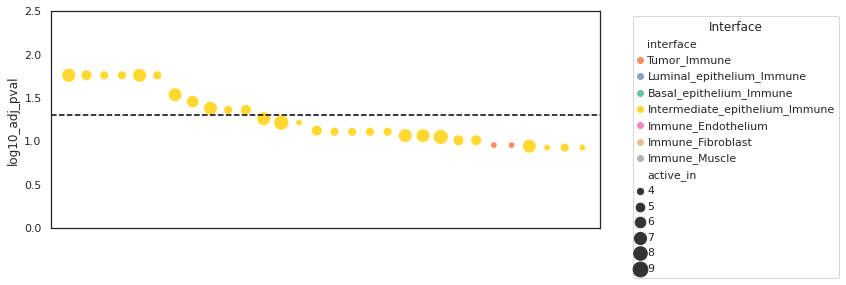

In [41]:
n_interaction = 30
plot_df = signif_pval_interactions[:n_interaction]
plot_df['interface'] = plot_df['interface'].astype('category').cat.set_categories(keys)
# Set the style of the plot
sns.set_style('white')
sns.set_palette([color_dict[r] for r in regions if r != roi])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 4))
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
#ax.axhline(y=2, color='black', linestyle='--')

# Create the dotplot
sns.scatterplot(x=plot_df.index, y='log10_adj_pval', size='active_in',
                hue='interface', data=plot_df, ax=ax, sizes=(40,400),
                size_norm=(4,14)
                )

# Set the y-axis limits and add dashed lines
ax.set_ylim(0, 2.5) # May need to adjust

ax.set_xlim(-1,n_interaction)


# Set the x-axis label and legend
ax.set_xlabel('Index')
ax.legend(title='Interface',bbox_to_anchor=(1.05, 1))
ax.set_xticklabels([])
ax.set_xlabel('')

plt.tight_layout()

if roi_is_target:
    plt.savefig('plots/interface_ligrec_dotplots/'+roi+'_as_target_fishers_test_adj_pval.pdf')
    signif_pval_interactions.to_csv('./plots/interface_ligrec_dotplots/'+roi+'_as_target_fishers_test_adj_pval.csv')
else:
    plt.savefig('plots/interface_ligrec_dotplots/'+roi+'_as_source_fishers_test__adj_pval.pdf')
    signif_pval_interactions.to_csv('./plots/interface_ligrec_dotplots/'+roi+'_as_source_fishers_test_adj_pval.csv')
# Show the plot
plt.show()


## Building a heatmap with the most common signaling

In [ ]:
def get_ligrec_df_format(roi, roi_is_target, regs = regions):

    if roi_is_target:
        which_molecule = 'ligand'
        anti_molecule = 'receptor'
    else:
        which_molecule = 'receptor'
        anti_molecule = 'ligand'

    prox_regions = [t for t in list(combinations(regs,2)) if roi in t]

    ## Download ligrec results and their metadata
    ligrec_results = {}
    meta_all = pd.DataFrame()

    for reg_couple in prox_regions:
        r1 = reg_couple[0]
        r2 = reg_couple[1]
        key = r1.replace(' ','_') + '_' + r2.replace(' ','_')

        # Load the data
        results_dict = load_from_pickle('./data/region_ligrec_analysis/v2_'+r1.replace(' ','_')+'_'+r2.replace(' ','_')+'_slides_with_ligrec.pkl')

        # Flip the direction if the region of interest (ROI) is second. This matches the direction of all comparisons, but can still be reversed if roi_is_target = True
        if roi == r2:
            r_temp = r2
            r2 = r1
            r1 = r_temp

        df_sum,meta = get_ligrec_results(results_dict, r1, r2, pval=0.05, reverse=roi_is_target)
        ligrec_results[key] = df_sum
        meta_all = pd.concat([meta_all,meta],axis=0)

    keys = list(ligrec_results.keys())
    meta_all.drop_duplicates(inplace=True)

    # Filtering samples
    sample_list = get_sample_ids_reorder(['BPH','untreated'])
    #sample_list = get_sample_ids_reorder(['bicalutamide','goserelin','CRPC'])

    # Filter out samples that are not of interest
    ligrec_results = filter_ligrec_results(ligrec_results,sample_list)

    ## Summarize the ligand-receptor pair results
    summarized_ligrec_results = {}
    for k in keys:
        df_sum = ligrec_results[k].copy()
        n_samples = df_sum.shape[1]
        pct_active = (~df_sum.isna()).sum(axis=1)#/n_samples ######## Here you can affect whether you look at percentages or numbers of samples
        mean_activity = df_sum.mean(axis=1)
        summarized_df_sum = pd.DataFrame({'mean':mean_activity,'pct_in':pct_active,'interaction':k})
        summarized_ligrec_results[k] = summarized_df_sum

    summarized_ligrec_df = pd.concat(summarized_ligrec_results.values(),axis=0)


    # Filtering interactions according to metadata annotation
    score_filter = 10
    meta = meta_all.copy()
    accepted_sources = ['CellPhoneDB']
    meta = meta[(meta['consensus_score_intercell_target']>score_filter) & (meta['consensus_score_intercell_source']>score_filter)]
    summarized_ligrec_df = summarized_ligrec_df.loc[meta.index.drop_duplicates()]

    summarized_ligrec_df['molecules'] = list(summarized_ligrec_df.index)
    summarized_ligrec_df['ligand'] = summarized_ligrec_df.index.get_level_values(0)
    summarized_ligrec_df['receptor'] = summarized_ligrec_df.index.get_level_values(1)

    return summarized_ligrec_df, interface_n

def get_top_interactions_sorted(df,sort_by,n_interactions=15):
    df = df[:n_interactions].copy()
    df['ligand'] = [i[0] for i in df.index]
    df['receptor'] = [i[1] for i in df.index]

    if sort_by == 'ligand':
        df = df.sort_values(['ligand','receptor']).drop(columns=['ligand','receptor'])

    if sort_by == 'receptor':
        df = df.sort_values(['receptor','ligand']).drop(columns=['ligand','receptor'])
    return(df)


In [ ]:
region_of_interest = 'Intermediate epithelium'
omit_col = ['Intermediate_epithelium_Endothelium'] # Too few interfaces (2)
n_ligrecs = 20

####################################################################################

ligrec_res_df, n_interfaces = get_ligrec_df_format(region_of_interest,roi_is_target=False)

# Pivot table to wide format
roi_as_source_df = ligrec_res_df.pivot_table(index='molecules',columns='interaction',values='pct_in').fillna(0)[keys]

# Normalize by the number of interfaces and drop redundant
roi_as_source_df = roi_as_source_df.div(n_interfaces,axis=1).drop(columns=omit_col)

# Sort values according to mean activity
roi_as_source_df = roi_as_source_df.loc[roi_as_source_df.mean(axis=1).sort_values(ascending=False).index]

# Sort according to interaction direction: roi as source --> sort by ligand
top_roi_as_source = get_top_interactions_sorted(roi_as_source_df,sort_by='ligand',n_interactions=n_ligrecs)


####################################################################################

ligrec_res_df, n_interfaces = get_ligrec_df_format(region_of_interest,roi_is_target=True)

# Pivot table to wide format
roi_as_target_df = ligrec_res_df.pivot_table(index='molecules',columns='interaction',values='pct_in').fillna(0)[keys]

# Normalize by the number of interfaces and drop redundant
roi_as_target_df = roi_as_target_df.div(n_interfaces,axis=1).drop(columns=omit_col)

# Sort values according to mean activity
roi_as_target_df = roi_as_target_df.loc[roi_as_target_df.mean(axis=1).sort_values(ascending=False).index]

# Sort according to interaction direction: roi as target --> sort by receptor
top_roi_as_target = get_top_interactions_sorted(roi_as_target_df,sort_by='receptor',n_interactions=n_ligrecs)

In [ ]:
upper_plot_df = pd.merge(top_roi_as_source,roi_as_target_df,left_index=True,right_index=True,how='left').fillna(0)
lower_plot_df = pd.merge(roi_as_source_df,top_roi_as_target,left_index=True,right_index=True,how='right').fillna(0)
plot_df = pd.concat([upper_plot_df,lower_plot_df],axis=0)

fig, ax = plt.subplots(figsize=(int(n_ligrecs/3),int(n_ligrecs/1.5)))
sns.heatmap(plot_df,cmap='Reds',square=True,xticklabels=False,ax=ax)
plt.savefig('./plots/interface_ligrec_dotplots/heatmap_most_prolific_interactions_'+region_of_interest+'_top_'+str(n_ligrecs)+'.pdf')
plt.show()

In [ ]:
for i in plot_df.index:
    print(i[1])

## DEGs and treatment effect

### Comparing ligrec-results to region markers

In [ ]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()

untreated = get_sample_ids_reorder(['BPH','untreated'])
treated = get_sample_ids_reorder(['bicalutamide','goserelin'])

In [ ]:
adata_concat = ad.concat(adata_slides)
adata_concat = adata_concat[adata_concat.obs['sample_id'].isin(treated + untreated)]

adata_concat.obs['treatment'] = adata_concat.obs['sample_id'].map(treat_info)
adata_concat.obs['treatment'] = adata_concat.obs['treatment'].replace({'bph':'untreated','bicalutamide':'treated','goserelin':'treated'})


adata_concat.obs['deg_group'] = adata_concat.obs['predicted_region'].astype(str) + '_' + adata_concat.obs['treatment'].astype(str)
adata_concat.obs['deg_group'] = adata_concat.obs['deg_group'].astype('category')

In [ ]:
reg = 'Tumor'
adata_region_subset = adata_concat[adata_concat.obs['predicted_region'] == reg]
sc.tl.rank_genes_groups(adata_region_subset,groupby='treatment', method='wilcoxon',random_state=1548962)

In [ ]:
# Code for testing whether a region has enrichment in overexpression of some gene
deg_lists = load_from_pickle('./data/region_gene_markers_signif_degs_231107.pkl')

reg = 'Immune'

df_signif = pd.DataFrame(columns=['gene','deg_untreated','deg_treated'])

pvals = []
df = deg_lists[reg]

unt_df = df[df['sample'].isin(untreated)]
treat_df = df[df['sample'].isin(treated)]

n_unt = len(unt_df['sample'].unique())
n_treat = len(treat_df['sample'].unique())

unt_val_counts = unt_df['names'].value_counts()
treat_val_counts = treat_df['names'].value_counts()

#gene_list = set(unt_val_counts.index[:500].tolist() + treat_val_counts.index[:500].tolist())
gene_list = set(unt_val_counts.index.tolist() + treat_val_counts.index.tolist())

for g in gene_list:
    if g not in unt_val_counts.index.tolist():
        a = 0
    else:
        a = unt_val_counts[g]
    if g not in treat_val_counts.index.tolist():
        c = 0
    else:
        c = treat_val_counts[g]
    
    b = n_unt - a
    d = n_treat - c

    df_signif = df_signif.append({'gene':g,'deg_untreated':a,'deg_treated':c},ignore_index=True)

    arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
    stat,pval = fisher_exact(arr,alternative='two-sided')
    pvals.append(pval)

df_signif['pval'] = pvals
df_signif = df_signif.sort_values('pval',ascending=True).reset_index(drop=True)
#adj_pvals = multipletests(pvals,method='fdr_bh')[1]
#df_signif['FDR'] = adj_pvals
#df_signif = df_signif.sort_values('FDR',ascending=True).reset_index(drop=True)

df_signif[:10]

In [ ]:
check_gene_marker_status('PCOLCE')

In [ ]:
check_top_markers('Intermediate epithelium')

In [ ]:
# Take DEG results and perform enrichment analysis:
# Compare the proportion of 'overexpressed' status in the same region
# for untreated vs treated samples
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

signif_pval_interactions = {}

for reg in regions:
    
    df = df_gene_counts.copy()
    other_keys = [c for c in df.columns if c != reg]

    n_sample = region_sample_counts[reg]
    n_control = pd.Series([region_sample_counts[k] for k in other_keys]).sum()

    df = df.sort_index()

    # Perform Fisher's exact test on all 
    for iact in df.index:
        a = df[reg].loc[[iact]]
        c = df[other_keys].sum(axis=1).loc[[iact]]
        b = n_sample-a
        d = n_control-c
        arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
        stat,pval = fisher_exact(arr,alternative='greater')
        df.loc[[iact],'pval'] = pval

    df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]


    df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                                'active_in':df[reg].astype(int).tolist(),
                                'adj_pval':df['adj_pval'].tolist(),
                                'interface':np.repeat(reg,len(df))})

    signif_pval_interactions[reg] = df_signif.copy()


date = datetime.now().strftime('%y%m%d')
save_to_pickle(signif_pval_interactions,'./data/region_gene_markers_fishers_exact_test_'+date+'.pkl')

## Interface numbers and ligr-rec signaling activity

### Data downloads

In [56]:
from itertools import combinations
region_combinations = list(combinations(regions,2))

## Download ligrec results and their metadata
ligrec_results_direct = {}
ligrec_results_reverse = {}
meta_all = pd.DataFrame()

for reg_couple in region_combinations:
    r1 = reg_couple[0]
    r2 = reg_couple[1]
    key = r1.replace(' ','_') + '_' + r2.replace(' ','_')

    # Load the data
    results_dict = load_from_pickle('./data/region_ligrec_analysis/v2_'+r1.replace(' ','_')+'_'+r2.replace(' ','_')+'_slides_with_ligrec.pkl')

    # Ligands in r1 & receptors in r2
    df_sum,meta = get_ligrec_results(results_dict, r1, r2, pval=0.05, reverse=False)
    ligrec_results_direct[key] = df_sum
    meta_all = pd.concat([meta_all,meta],axis=0)
    
    # Ligands in r2 & receptors in r1
    df_sum,meta = get_ligrec_results(results_dict, r1, r2, pval=0.05, reverse=True)
    ligrec_results_reverse[key] = df_sum
    meta_all = pd.concat([meta_all,meta],axis=0)


In [57]:
# Collect keys (apply to both dicts)
keys = list(ligrec_results_direct.keys())

# Filter metadata
score_filter = 10
meta_filtered = meta_all[(meta_all['consensus_score_intercell_target']>score_filter) & (meta_all['consensus_score_intercell_source']>score_filter)].drop_duplicates()

In [58]:
def summarize_ligrec_results(res_dict,keys_list=keys):
    summarized_ligrec_results = {}
    for k in keys_list:
        df_sum = res_dict[k].copy()
        n_samples = df_sum.shape[1]
        pct_active = (~df_sum.isna()).sum(axis=1)#/n_samples ######## Here you can affect whether you look at percentages or numbers of samples
        mean_activity = df_sum.mean(axis=1)
        summarized_df_sum = pd.DataFrame({'mean':mean_activity,'active_in':pct_active.astype(int),'interface':k, 'n_interfaces':n_samples})
        summarized_ligrec_results[k] = summarized_df_sum

    summarized_ligrec_df = pd.concat(summarized_ligrec_results.values(),axis=0)
    return(summarized_ligrec_df)

def format_ligrec_activity_results(sum_res,meta=meta_filtered):
    # Filter out ligrec-pairs that don't fill the inclusion criteria (score = 10)
    sum_res = sum_res.loc[pd.Index([tup for tup in meta.index if tup in sum_res.index])]

    # Drop redundant rows
    sum_res = sum_res[~(sum_res['active_in'] == 0)]

    # Count the number of unique ligand-receptor pairs
    sum_res['active_in'] = sum_res['interface'].map(sum_res.value_counts('interface'))

    return sum_res

### Treatment effect on signaling activity

In [59]:

# Modify reverse dictionary keys to avoid overlap
for k in keys:
    ligrec_results_reverse[k+'_reverse'] = ligrec_results_reverse[k].copy()
    del ligrec_results_reverse[k]

# Combine the dictionaries into a single one
combined_ligrec_results_dict = {**ligrec_results_direct,**ligrec_results_reverse}

# Get the keys
combined_keys = list(combined_ligrec_results_dict.keys())

# Get sample annotations
untreated_samples = get_sample_ids_reorder(['BPH','untreated'])
treated_samples = get_sample_ids_reorder(['bicalutamide','goserelin'])

In [60]:
comb_ligrec_res_unt = {}
comb_ligrec_res_trt = {}

for k in combined_keys:
    df = combined_ligrec_results_dict[k].copy()
    comb_ligrec_res_unt[k] = df[[s for s in untreated_samples if s in df.columns]].copy()
    comb_ligrec_res_trt[k] = df[[s for s in treated_samples if s in df.columns]].copy()

In [61]:
# Summarize the results into long format
untreated_results = summarize_ligrec_results(comb_ligrec_res_unt,keys_list=combined_keys)
treated_results = summarize_ligrec_results(comb_ligrec_res_trt,keys_list=combined_keys)

# Filter out ligrec-pairs that don't fill the inclusion criteria (score = 10)
untreated_results = untreated_results.loc[pd.Index([tup for tup in meta_filtered.index if tup in untreated_results.index])]
treated_results = treated_results.loc[pd.Index([tup for tup in meta_filtered.index if tup in treated_results.index])]

# Calulating a activity score for both the treated and the untreated class: log(n_active+1)/log(n_interfaces+1)
untreated_results['activity_score'] = np.log(untreated_results['active_in']+1)/np.log(untreated_results['n_interfaces']+1)
treated_results['activity_score'] = np.log(treated_results['active_in']+1)/np.log(treated_results['n_interfaces']+1)

#untreated_results['activity_score'] = untreated_results['active_in'] / untreated_results['n_interfaces']
#treated_results['activity_score'] = treated_results['active_in'] / treated_results['n_interfaces']

untreated_results = untreated_results.rename(columns=dict(zip(untreated_results.columns, [c+'_unt' if c != 'interface' else c for c in untreated_results.columns] ))).reset_index()
treated_results = treated_results.rename(columns=dict(zip(treated_results.columns, [c+'_trt' if c != 'interface' else c for c in treated_results.columns] ))).reset_index()

In [62]:
final_merged_results = pd.merge(untreated_results,treated_results,on=['source','target','interface'],how='outer').fillna(0)


### NOTE!!! Changed the order so that signaling going up after treatment gets positive values and vice-versa
final_merged_results['treatment_effect_score'] = final_merged_results['activity_score_trt'] - final_merged_results['activity_score_unt'] 

# Create mapping dicts for extracting interactions
interface_sources_dict = dict(zip(combined_keys,[tup[0] for tup in region_combinations] + [tup[1] for tup in region_combinations]))
interface_targets_dict = dict(zip(combined_keys,[tup[1] for tup in region_combinations] + [tup[0] for tup in region_combinations]))

# Drop endothelium and get the results
final_merged_results = final_merged_results[~(final_merged_results['interface'].str.contains('Endothelium'))].sort_values('treatment_effect_score',ascending=False).reset_index(drop=True)
final_merged_results['source_interface'] = final_merged_results['interface'].map(interface_sources_dict)
final_merged_results['target_interface'] = final_merged_results['interface'].map(interface_targets_dict)
final_df = final_merged_results[['source_interface','target_interface','source','target','active_in_unt','n_interfaces_unt','active_in_trt','n_interfaces_trt','treatment_effect_score']]
final_df['ligand_receptor_pair'] = list(zip(final_df['source'],final_df['target']))

In [63]:
final_df[final_df['ligand_receptor_pair'] == ('CCL20','CCR6')]

,source_interface,target_interface,source,target,active_in_unt,n_interfaces_unt,active_in_trt,n_interfaces_trt,treatment_effect_score,ligand_receptor_pair
436,Intermediate epithelium,Luminal epithelium,CCL20,CCR6,0,14,3,8,0.630930,"(CCL20, CCR6)"
845,Intermediate epithelium,Basal epithelium,CCL20,CCR6,1,9,7,10,0.566164,"(CCL20, CCR6)"
3678,Basal epithelium,Immune,CCL20,CCR6,1,5,4,8,0.345634,"(CCL20, CCR6)"
5561,Luminal epithelium,Tumor,CCL20,CCR6,0,16,1,8,0.315465,"(CCL20, CCR6)"
5580,Muscle,Immune,CCL20,CCR6,0,10,1,8,0.315465,"(CCL20, CCR6)"
8405,Muscle,Basal epithelium,CCL20,CCR6,0,12,1,10,0.289065,"(CCL20, CCR6)"
10949,Muscle,Fibroblast,CCL20,CCR6,0,16,1,11,0.278943,"(CCL20, CCR6)"
11109,Tumor,Muscle,CCL20,CCR6,0,12,1,11,0.278943,"(CCL20, CCR6)"
14807,Intermediate epithelium,Muscle,CCL20,CCR6,4,13,5,9,0.168298,"(CCL20, CCR6)"
15756,Intermediate epithelium,Fibroblast,CCL20,CCR6,2,14,2,7,0.122637,"(CCL20, CCR6)"


### Intermediate epithelium --> Immune

In [ ]:
df = final_df[final_df['source_interface']=='Intermediate epithelium'][final_df['target_interface']=='Immune'].reset_index(drop=True)

df['count'] = 1
df = df[(df['active_in_trt']>=3) | (df['active_in_unt']>=3)]
agg_df = df.groupby('source').aggregate({'treatment_effect_score':'mean','count':'sum'}).sort_values('treatment_effect_score',ascending=False)
agg_df = agg_df[agg_df['count']>=4]
agg_df[-10:]

In [ ]:
source_genes = [
    'CCL20',
    'CXCL1',
    'CXCL2',
    'CXCL8',
    'SAA1',
    'CCL3',
    'IL6',
    'WNT5A'
    ]


In [ ]:
# Looking at Intermediate epithelium as source

df = final_df[final_df['source_interface']=='Intermediate epithelium'][final_df['target_interface']=='Immune'][final_df['source'].isin(source_genes)].reset_index(drop=True)

plot_df = pd.DataFrame()
for g in source_genes:
    plot_df = pd.concat([plot_df,df[df['source']==g].sort_values('treatment_effect_score',ascending=False)])
plot_df = plot_df.reset_index(drop=True)

# This filters out the most sporadic signaling:
plot_df = plot_df[(plot_df['active_in_trt']>=3) | (plot_df['active_in_unt']>=3)]
plot_df = plot_df.reset_index(drop=True)

plot_df = plot_df.reset_index()


pal = sns.color_palette('tab10',len(source_genes))
ligrec_palette = dict(zip(source_genes,pal))
source_colors = plot_df['source'].map(ligrec_palette)

fig,ax = plt.subplots(figsize=(18,4))
sns.barplot(plot_df,x='index',y='treatment_effect_score',ax=ax,palette=source_colors)#
ax.set_ylim(-1.0,1.0)
ax.set_xticklabels([])


import matplotlib.patches as mpatches
# Create a list of Patch objects, where each object represents a colored patch for each gene
patches = [mpatches.Patch(color=color, label=gene) for gene, color in ligrec_palette.items()]

# Create the legend using the patches list
ax.legend(handles=patches,bbox_to_anchor=(1.0,0.8))

plt.tight_layout()
#plt.savefig('plots/receptor_ligand_interaction_analysis/treatment_effect/intermediate_immune_sources_barplot.pdf')
#plot_df.to_csv('plots/receptor_ligand_interaction_analysis/treatment_effect/intermediate_immune_sources.csv')

plt.show()

### Immune --> Intermediate epithelium

In [ ]:
df = final_df[final_df['source_interface']=='Immune'][final_df['target_interface']=='Intermediate epithelium'].reset_index(drop=True)

df['count'] = 1
df = df[(df['active_in_trt']>=3) | (df['active_in_unt']>=3)]
agg_df = df.groupby('target').aggregate({'treatment_effect_score':'mean','count':'sum'}).sort_values('treatment_effect_score',ascending=False)
agg_df[agg_df['count']>=3][:20]
#agg_df[-20:]

In [ ]:
target_genes = [
                'CXCR3',
                'MST1R',
                'MET',
                'EGFR',
                'FGFR2',
                'ITGB1',
                'CXCR5',
                ]

In [ ]:
# Looking at Intermediate epithelium as source

df = final_df[final_df['source_interface']=='Immune'][final_df['target_interface']=='Intermediate epithelium'][final_df['target'].isin(target_genes)].reset_index(drop=True)

plot_df = pd.DataFrame()
for g in target_genes:
    plot_df = pd.concat([plot_df,df[df['target']==g].sort_values('treatment_effect_score',ascending=False)])

# This filters out the most sporadic signaling:
plot_df = plot_df[(plot_df['active_in_trt']>=3) | (plot_df['active_in_unt']>=3)]
plot_df = plot_df.reset_index(drop=True)

plot_df = plot_df.reset_index()

pal = sns.color_palette('Dark2',len(target_genes))
ligrec_palette = dict(zip(target_genes,pal))
source_colors = plot_df['target'].map(ligrec_palette)

fig,ax = plt.subplots(figsize=(18,4))
sns.barplot(plot_df,x='index',y='treatment_effect_score',ax=ax,palette=source_colors)#
ax.set_ylim(-1.0,1.0)
ax.set_xticklabels([])


import matplotlib.patches as mpatches
# Create a list of Patch objects, where each object represents a colored patch for each gene
patches = [mpatches.Patch(color=color, label=gene) for gene, color in ligrec_palette.items()]

# Create the legend using the patches list
ax.legend(handles=patches,bbox_to_anchor=(1.0,0.8))

plt.tight_layout()
plt.savefig('plots/receptor_ligand_interaction_analysis/treatment_effect/immune_intermediate_targets_barplot.pdf')
plot_df.to_csv('plots/receptor_ligand_interaction_analysis/treatment_effect/immune_intermediate_targets.csv')

plt.show()

### Formatting dotplot 3b

In [ ]:
# On second thought : Keep all the samples
""" 
# Filter samples in ligrec results
# Include only untreated (treatment-naive)
valid_sample_ids = get_sample_ids_reorder(['BPH','untreated'])
ligrec_results_direct = filter_ligrec_results(ligrec_results_direct,valid_sample_ids)
ligrec_results_reverse = filter_ligrec_results(ligrec_results_reverse,valid_sample_ids)
 """

In [ ]:
# This takes the number of unique signaling pairs active in the data
""" 
sum_res_direct = format_ligrec_activity_results(summarize_ligrec_results(ligrec_results_direct))
sum_res_reverse = format_ligrec_activity_results(summarize_ligrec_results(ligrec_results_reverse))
final_res_direct = sum_res_direct[['interface','n_interfaces','active_in']].groupby('interface').first()
final_res_reverse = sum_res_reverse[['interface','n_interfaces','active_in']].groupby('interface').first()
 """
 
# This takes the total number of active pairs
final_res_direct = summarize_ligrec_results(ligrec_results_direct)[['interface','active_in','n_interfaces']].groupby('interface').agg({'active_in':'sum','n_interfaces':'first'})
final_res_reverse = summarize_ligrec_results(ligrec_results_reverse)[['interface','active_in','n_interfaces']].groupby('interface').agg({'active_in':'sum','n_interfaces':'first'})


In [ ]:


# Add missing values in manually (at least 'Basal_epithelium_Endothelium')
for missing_key in [k for k in keys if k not in final_res_direct.index]:
    final_res_direct.loc[missing_key] = [0, 0]
    final_res_reverse.loc[missing_key] = [0, 0]


# Set the region in a correct order
final_res_direct = final_res_direct.loc[keys]
final_res_direct['region1'] = pd.Categorical([tup[0] for tup in region_combinations]).set_categories(regions)
final_res_direct['region2'] = pd.Categorical([tup[1] for tup in region_combinations]).set_categories(regions)

# Set the regions in reverse order
final_res_reverse = final_res_reverse.loc[keys]
final_res_reverse['region1'] = pd.Categorical([tup[1] for tup in region_combinations]).set_categories(regions)
final_res_reverse['region2'] = pd.Categorical([tup[0] for tup in region_combinations]).set_categories(regions)


# Normalize the number of active signaling routes by the number of region interfaces
final_res_direct['active_in_normalized'] = final_res_direct['active_in']/final_res_direct['n_interfaces']
final_res_reverse['active_in_normalized'] = final_res_reverse['active_in']/final_res_reverse['n_interfaces']

In [ ]:
sns.set_theme(style='white')
drop_endothelium = True
pal = sns.diverging_palette(250, 10, s=100, l=50, center='dark',n=5) 
#pal = sns.color_palette("RdBu_r", 5)

In [ ]:

df = pd.concat([final_res_direct,final_res_reverse])

if drop_endothelium:
    df = df[~(df.index.str.contains('Endothelium'))]
    df['region1'] = df['region1'].cat.remove_categories('Endothelium')
    df['region2'] = df['region2'].cat.remove_categories('Endothelium')

# Making a discrete variable for mapping
num_bins = 5  # Number of bins for discretization
labels = ['Low', 'Medium', 'High', 'Very High', 'Extreme']  # Labels for each bin
df['n_active_ligrecs_discrete'] = pd.cut(df['active_in_normalized'], bins=num_bins, labels=labels)

fig, ax = plt.subplots(figsize=(5,5),dpi=120)

sns.scatterplot(y='region1', x='region2', size='n_interfaces',
 hue='n_active_ligrecs_discrete', sizes=(100, 12e2),
 palette=pal, data=df,edgecolor=None, ax=ax)

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),markerscale=0.4)

# Modify axes limits to fit all dots in
ax.set_xlim([-1, len(df.region1.unique())])
ax.set_ylim([len(df.region1.unique()), -1])

ax.set_xticklabels(ax.get_xticklabels() , rotation=15)
plt.savefig('./plots/interface_ligrec_dotplots/interface_prevalence_and_signaling_activity.pdf')

plt.show()


## Chemokine signaling heatmap with treatment effect (Figure 4c)

In [4]:
chemokine_markers = pd.read_csv('./chemokine_signaling_genes.csv',sep=';')

unt_samples = get_sample_ids_reorder(['BPH','untreated'])
trt_samples = get_sample_ids_reorder(['bicalutamide','goserelin'])

In [5]:
def fetch_mean_expression(region, gene_markers, sample_list, slides = adata_slides):
    '''
    Returns the per-sample mean expression of genes of interest across all samples that are defined in sample_list
    inside a region defined by region parameter.
    '''

    final_expression_df = pd.DataFrame()
    for sample in sample_list:

        slide = slides[sample].copy()
        slide_subs = slide[slide.obs['predicted_region']==region].copy()

        # Control for the number of data points belonging to a class
        if slide_subs.shape[0] >= 10:

            present_genes = [g for g in gene_markers if g in slide_subs.var_names]
            missing_genes = [g for g in gene_markers if g not in slide_subs.var_names]

            genes_all_arr_order_match = present_genes + missing_genes

            mean_expr_without_missing_genes = slide_subs[:,present_genes].X.copy().mean(axis=0)
            mean_expr_all = np.concatenate((mean_expr_without_missing_genes,np.repeat(np.nan,len(missing_genes))))

            expr_as_df = pd.DataFrame(data=mean_expr_all,index=genes_all_arr_order_match,columns=[sample])
            expr_as_df = expr_as_df.loc[gene_markers]
            final_expression_df = pd.concat([final_expression_df,expr_as_df],axis=1)

    return(final_expression_df)

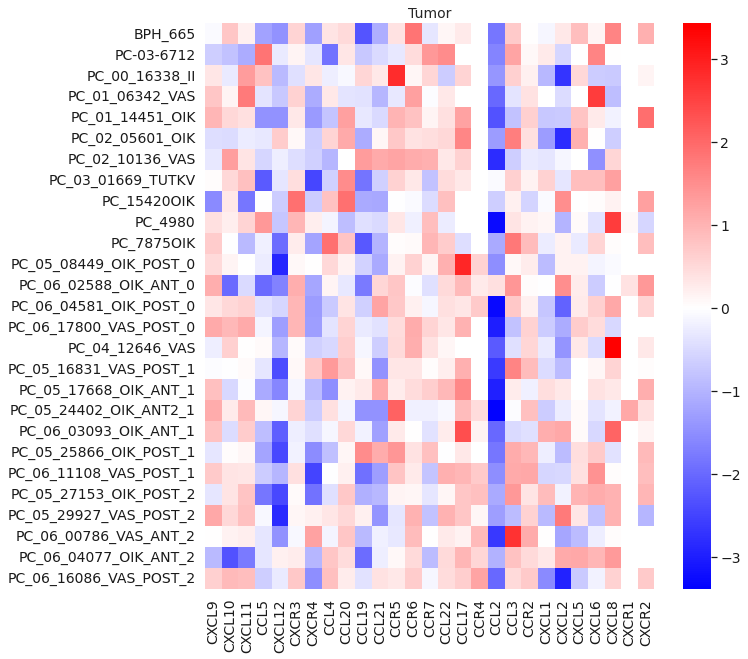

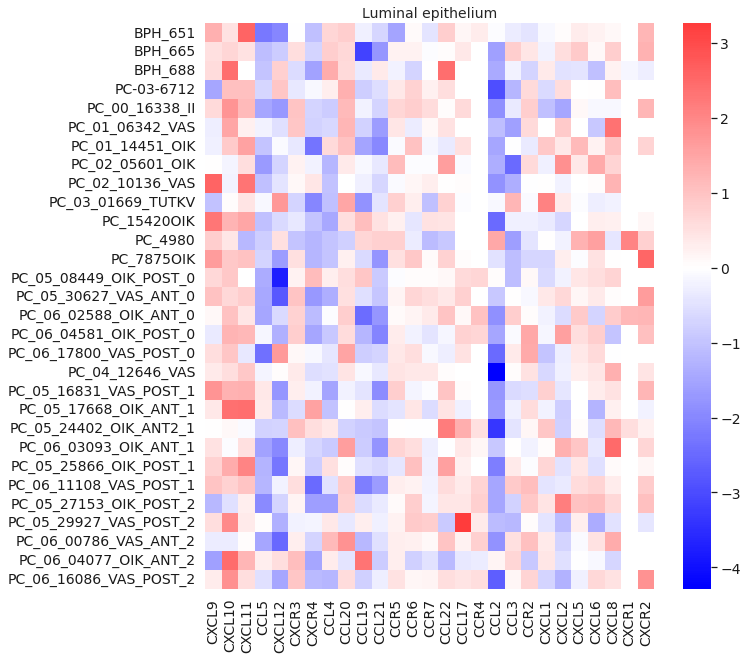

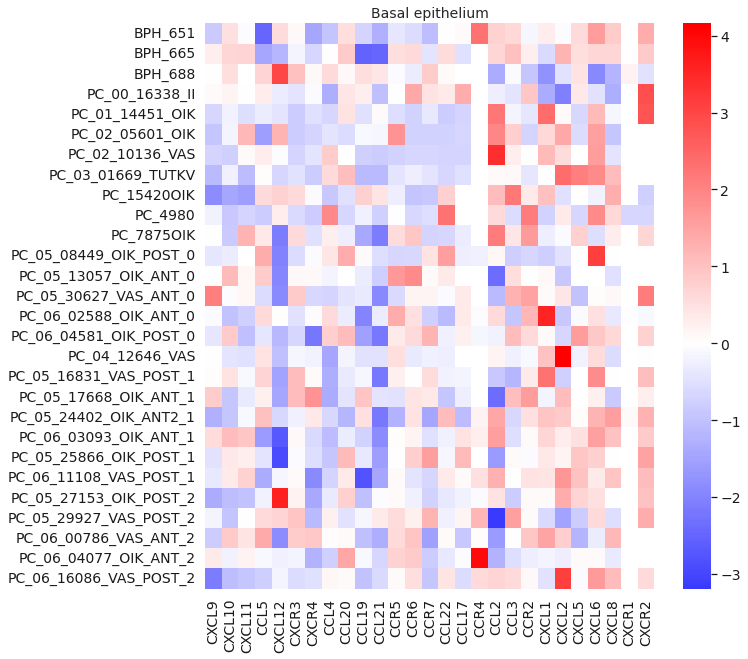

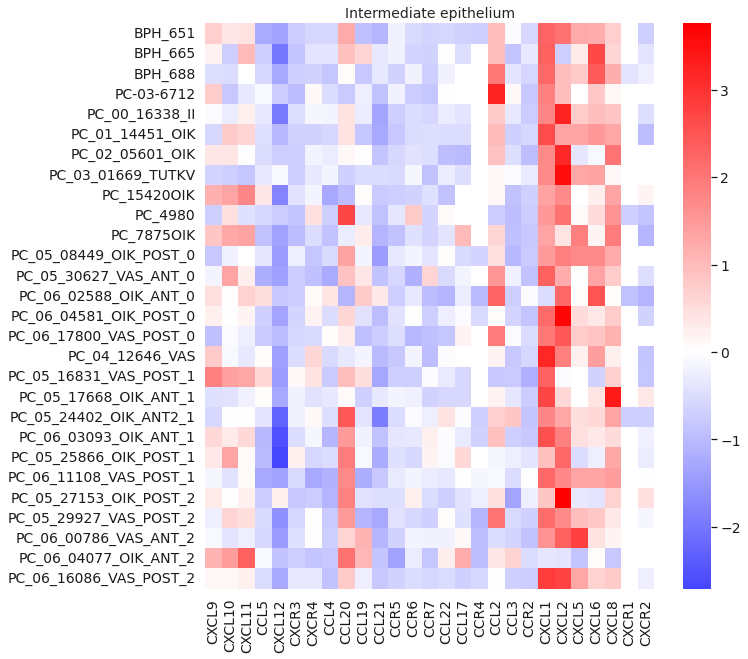

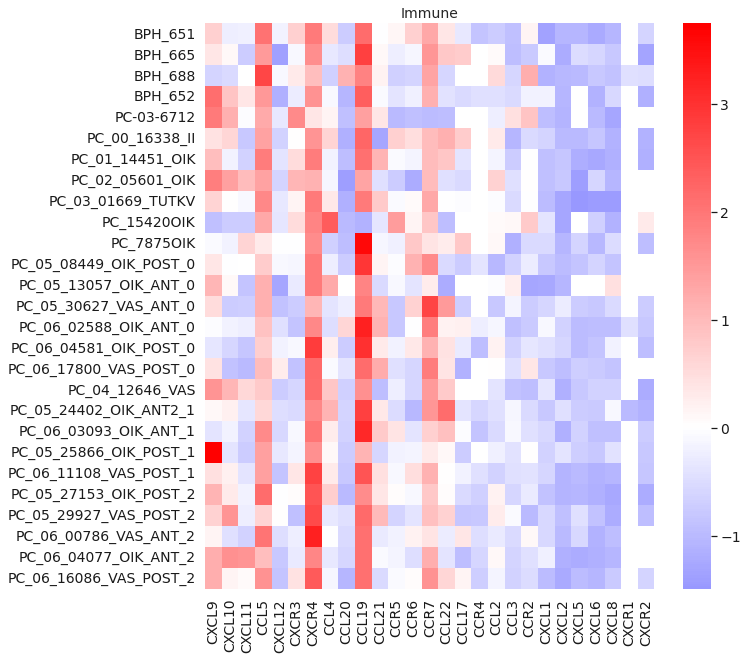

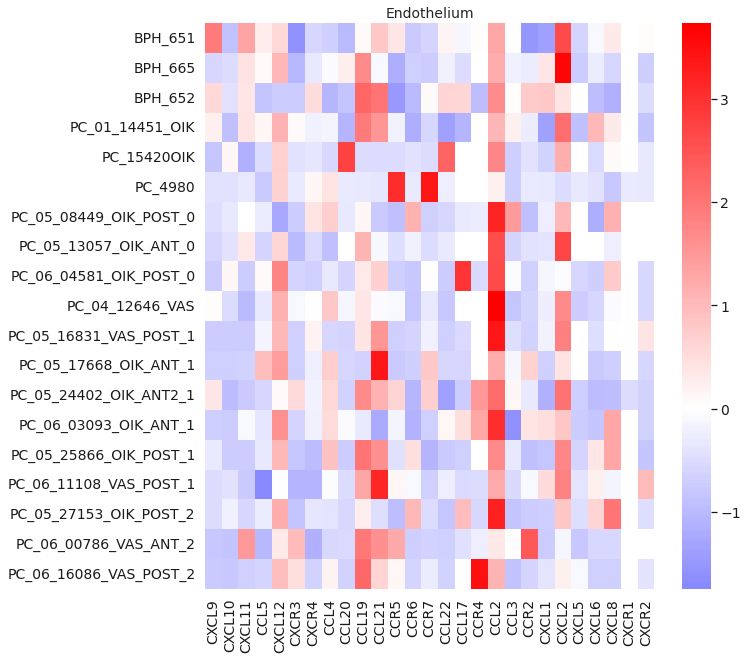

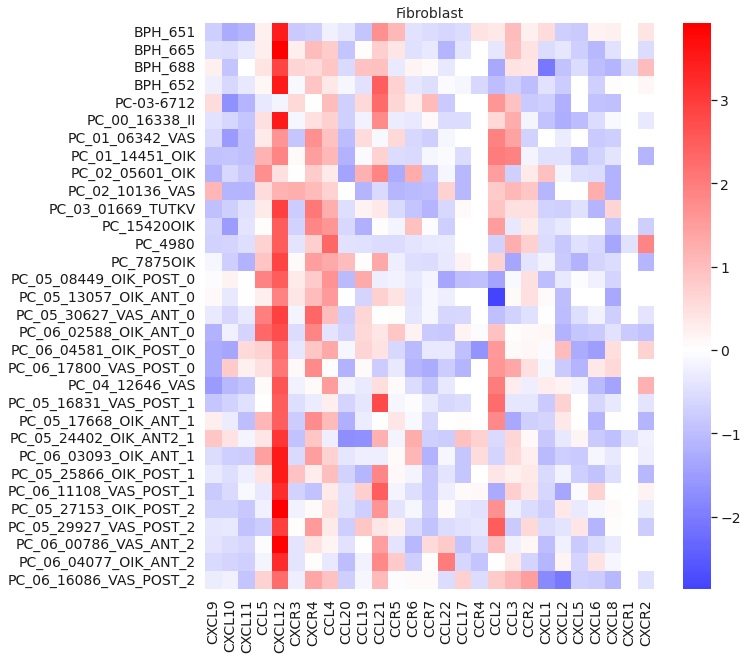

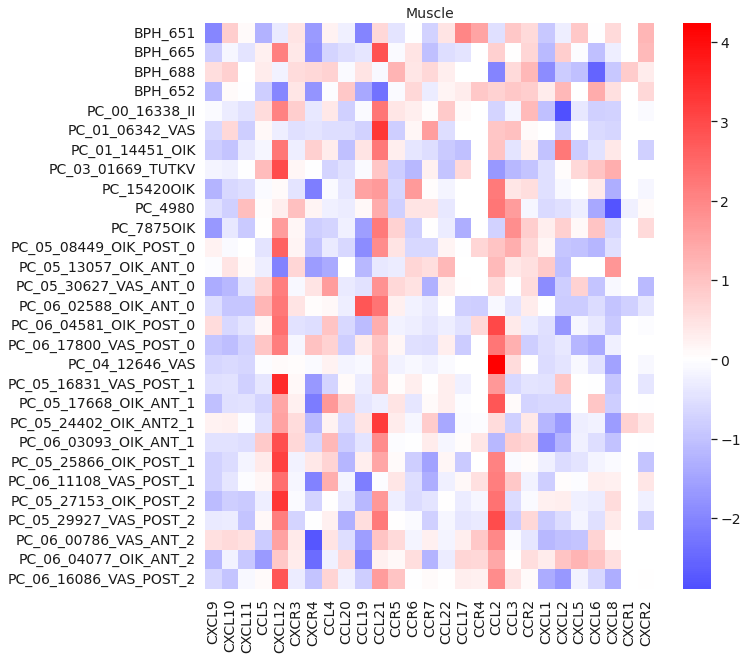

In [55]:
chemokine_markers_list = chemokine_markers['gene'].unique().tolist()

for reg in regions:

    untreated = fetch_mean_expression(reg, chemokine_markers_list, unt_samples)
    treated = fetch_mean_expression(reg, chemokine_markers_list, trt_samples)

    plot_df = pd.concat([untreated,treated],axis=1)
    plot_df = plot_df.apply(lambda x: zscore(x, nan_policy='omit')).T

    # Set figure size
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the heatmap
    sns.heatmap(plot_df, center=0, cmap='bwr',ax=ax)

    ax.set_title(reg)
    # Display the plot
    plt.show()

In [6]:

def fetch_region_wide_gene_expression(gene_markers, sample_list, slides = adata_slides, regions_list = regions):
    '''
    Returns the per-sample mean expression of genes of interest across all samples that are defined in sample_list
    inside a region defined by region parameter.
    '''
    
    
    final_expression_df = pd.DataFrame()

    for region in regions_list:

        region_expression_df = pd.DataFrame()
        for sample in sample_list:

            slide = slides[sample].copy()

            slide_subs = slide[slide.obs['predicted_region']==region].copy()

            # Control for the number of data points belonging to a class
            if slide_subs.shape[0] >= 10:

                present_genes = [g for g in gene_markers if g in slide_subs.var_names]
                missing_genes = [g for g in gene_markers if g not in slide_subs.var_names]

                genes_all_arr_order_match = present_genes + missing_genes

                expr_without_missing_genes = slide_subs[:,present_genes].X.copy()
                mean_expr_all = np.concatenate((expr_without_missing_genes,np.full((expr_without_missing_genes.shape[0],len(missing_genes)), np.nan)),axis=1)

                expr_as_df = pd.DataFrame(data=mean_expr_all.T,index=genes_all_arr_order_match,columns=slide_subs.obs_names)
                expr_as_df = expr_as_df.loc[gene_markers]
                #expr_as_df.loc['sample'] = sample
                region_expression_df = pd.concat([region_expression_df,expr_as_df],axis=1)

        print(region + ' done')
        final_expression_df = pd.concat([final_expression_df,region_expression_df.mean(axis=1)],axis=1)
    
    final_expression_df.columns = regions_list
    return(final_expression_df)

In [8]:

chemokine_markers_list = chemokine_markers['gene'].unique().tolist()

#untreated = fetch_region_wide_gene_expression(chemokine_markers_list, unt_samples)
treated = fetch_region_wide_gene_expression(chemokine_markers_list, trt_samples)


Tumor done
Luminal epithelium done
Basal epithelium done
Intermediate epithelium done
Immune done
Endothelium done
Fibroblast done
Muscle done


,CXCL9,CXCL10,CXCL11,CCL5,CXCL12,CXCR3,CXCR4,CCL4,CCL5,CCL20,...,CCL5,CCR2,CCR5,CXCL1,CXCL2,CXCL5,CXCL6,CXCL8,CXCR1,CXCR2
Tumor,-0.043838,-0.045776,-0.042031,-0.091313,-0.093873,-0.037585,-0.109504,-0.069361,-0.091313,-0.035950,...,-0.091313,-0.044934,-0.030310,-0.075717,-0.096418,-0.047248,-0.045993,-0.038566,-0.013593,-0.012560
Luminal epithelium,-0.040848,-0.006856,-0.011262,-0.120919,-0.109526,-0.035992,-0.124721,-0.087141,-0.120919,-0.021123,...,-0.120919,-0.041951,-0.044557,-0.081620,-0.056647,-0.035306,-0.052094,-0.026395,0.011000,-0.001407
Basal epithelium,-0.043267,-0.036525,-0.055777,-0.064011,-0.074559,-0.039307,-0.095874,-0.033457,-0.064011,-0.011068,...,-0.064011,0.006383,-0.029338,-0.020852,-0.012546,-0.003453,0.022140,-0.021359,-0.024061,0.037723
Intermediate epithelium,0.256307,0.264178,0.353837,0.089120,-0.164550,0.030226,0.155776,0.098064,0.089120,0.344246,...,0.089120,0.048056,0.067366,0.839216,0.874452,0.449859,0.675573,0.518256,0.052581,0.043500
Immune,0.770191,0.500060,0.361057,1.114631,0.236883,0.504077,1.359057,0.546632,1.114631,0.150352,...,1.114631,0.363603,0.410097,0.196409,0.032715,0.045441,0.037532,0.108570,0.351935,0.020210
Endothelium,0.067791,0.018109,0.141778,0.016013,0.237854,-0.050002,0.069964,0.012431,0.016013,0.052246,...,0.016013,0.057106,0.000972,0.078469,0.550486,-0.075058,-0.003473,0.049770,-0.077197,-0.020109
Fibroblast,-0.011657,-0.031635,-0.018093,0.112485,0.314120,0.035148,0.148547,0.126810,0.112485,-0.018098,...,0.112485,0.034422,0.050902,0.009650,-0.024199,-0.041734,-0.018949,-0.005405,-0.044594,0.014387
Muscle,-0.069370,-0.049143,-0.049171,-0.027145,0.020620,-0.015427,-0.068180,-0.016025,-0.027145,-0.042481,...,-0.027145,-0.001829,-0.024539,-0.065654,-0.055045,-0.033143,-0.056253,-0.056607,-0.027593,-0.019553
Tumor,-0.097812,-0.126120,-0.096485,-0.148940,-0.192322,-0.068769,-0.156162,-0.053807,-0.148940,-0.042251,...,-0.148940,-0.037642,-0.063826,-0.085720,-0.098589,-0.039617,-0.042502,-0.015167,0.006219,-0.043287
Luminal epithelium,-0.041561,0.034148,0.034488,-0.171914,-0.229462,-0.060666,-0.174462,-0.167732,-0.171914,-0.028950,...,-0.171914,-0.036707,-0.062472,-0.083608,-0.105095,-0.062565,-0.081210,-0.018474,-0.031311,-0.002635


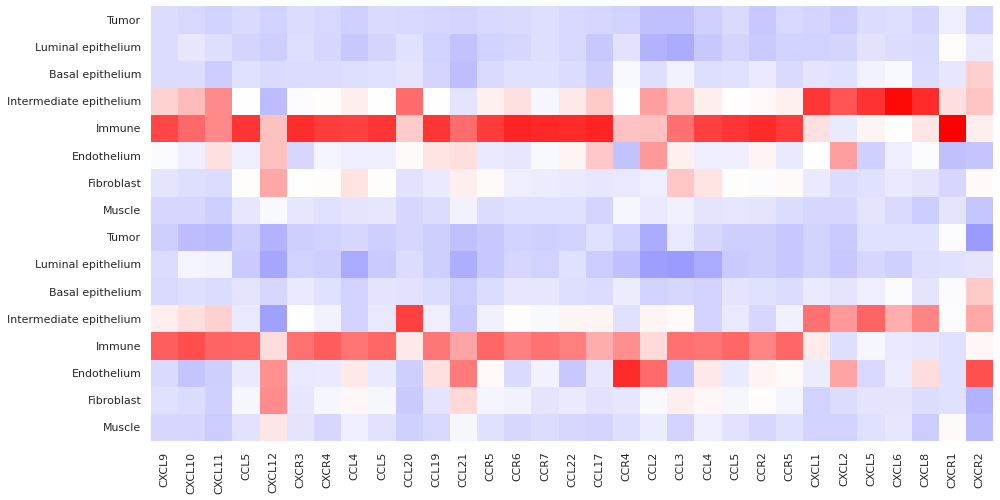

In [31]:
from scipy.stats import zscore

sns.set_theme(style='white')
plot_df = pd.concat([untreated,treated],axis=1).T
plot_df = plot_df.apply(lambda x: zscore(x, nan_policy='omit'))
plot_df = plot_df[chemokine_markers['gene']]

# Set figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the heatmap
sns.heatmap(plot_df, center=0, cmap='bwr', square=True, ax=ax,cbar=False)

# Display the plot
plt.savefig('plots/normalized_gene_expression_heatmaps/chemokine_signaling_key_genes.pdf')
plt.show()

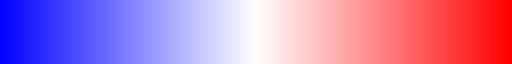

In [57]:
sns.color_palette('bwr',as_cmap=True)